## Compare phenotype performance between time periods

In [ ]:
import os
import yaml

import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from SALib.analyze import rbd_fast

from palettable.colorbrewer.sequential import YlGn_9
from palettable.cmocean.sequential import Tempo_10
from palettable.colorbrewer.diverging import PuOr_7

from ideotype.utils import fold
from ideotype.data_process import read_sims, read_data, parse_mature
from ideotype.nass_process import read_nass, nass_summarize
from ideotype.init_params import params_sample
from ideotype.data_process import agg_sims
from ideotype.analysis import (identify_top_phenos,
                               top_pheno_prevalence,
                               prevalent_top_pheno,
                               rank_all_phenos)
from ideotype import DATA_PATH

In [2]:
# Read in sims
sims_present = pd.read_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_present.csv')
sims_f2050 = pd.read_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_f2050.csv')
sims_f2100 = pd.read_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_f2100.csv')

In [3]:
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_present.yml')
df_extended, df_stuck = parse_mature(df_all)

In [4]:
def rank_diff(run_name):
    # Determine rank change - f2050
    ranks_present = []
    ranks_future = []
    rank_diffs = []

    for pheno in phenos_ranked_present:
        rank_present = df_ranks.query(f'pheno_present == {pheno}')['rank'].item()
        rank_future = df_ranks.query(f'pheno_{run_name} == {pheno}')['rank'].item()
        rank_diff = rank_present - rank_future
        ranks_present.append(rank_present)
        ranks_future.append(rank_future)
        rank_diffs.append(rank_diff)
    
    return(rank_diffs)

In [5]:
def plot_rankdiff(year):
    for item in np.arange(100):
        if rank_diffs[item] < 0:
            plt.arrow(ranks_present[item], item, 0, rank_diffs[item]*-1, 
                      head_width=0.8,
                      length_includes_head=True,
                      head_starts_at_zero=True,
                      color='tab:orange')
        else:
            plt.arrow(ranks_present[item], item, 0, rank_diffs[item]*-1, 
                      head_width=0.8,
                      length_includes_head=True,
                      color='tab:purple')
    rect = plt.Rectangle((-1,-1), 110, 21,
                     facecolor='grey', alpha=0.1)
    ax.add_patch(rect)
    plt.ylabel('ranking', fontweight='light', size=14)
    ax.set_xlim(-1,101)
    ax.set_ylim(-1,101)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(0,100))
    ax.set_xticklabels(df_ranks.pheno_present[:], fontweight='light', fontsize=8, rotation=90)
    ax.text(95,10,f'{year}', fontweight='light')

## Visualize change in phenotype ranking 
Under years 2050 & 2100 and with different yield & dispersion weight

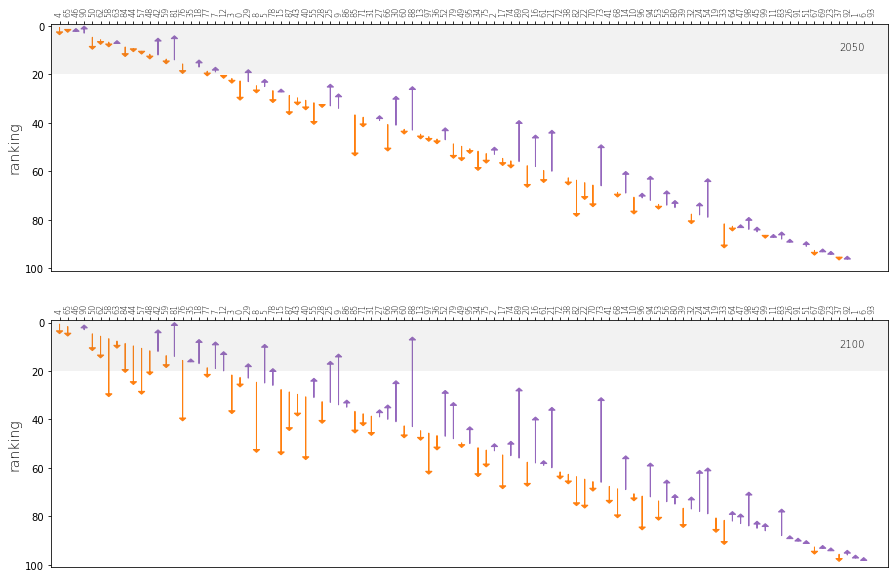

In [6]:
# Rank all phenos
n_pheno = 100
w_yield = 0.5
w_disp = 0.5

df_rankings, phenos_ranked_present = rank_all_phenos('present', n_pheno, w_yield, w_disp)
df_rankings, phenos_ranked_f2050 = rank_all_phenos('f2050', n_pheno, w_yield, w_disp)
df_rankings, phenos_ranked_f2100 = rank_all_phenos('f2100', n_pheno, w_yield, w_disp)

df_ranks = pd.DataFrame({'pheno_present': phenos_ranked_present,
                         'pheno_f2050': phenos_ranked_f2050,
                         'pheno_f2100': phenos_ranked_f2100,
                         'rank': np.arange(100)})

df_ranks['rankdiff_2050'] = rank_diff('f2050')
df_ranks['rankdiff_2100'] = rank_diff('f2100')

# Set up figure
fig = plt.figure(figsize=(15,10))

# Rank change - f2050
rank_diffs = rank_diff('f2050')
ranks_present = df_ranks['rank']
ax = fig.add_subplot(2,1,1)
plot_rankdiff(2050)

# Rank change - f2100
rank_diffs = rank_diff('f2100')
ax = fig.add_subplot(2,1,2)
plot_rankdiff(2100)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/rankchange_y50_d50.png', format='png', dpi=800)

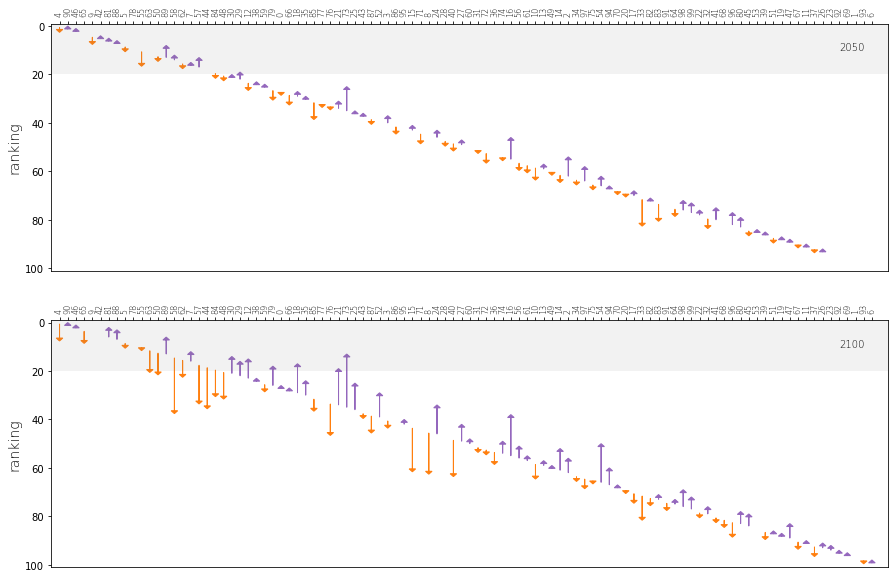

In [7]:
# Rank all phenos
n_pheno = 100
w_yield = 0.8
w_disp = 0.2

df_rankings, phenos_ranked_present = rank_all_phenos('present', n_pheno, w_yield, w_disp)
df_rankings, phenos_ranked_f2050 = rank_all_phenos('f2050', n_pheno, w_yield, w_disp)
df_rankings, phenos_ranked_f2100 = rank_all_phenos('f2100', n_pheno, w_yield, w_disp)

df_ranks = pd.DataFrame({'pheno_present': phenos_ranked_present,
                         'pheno_f2050': phenos_ranked_f2050,
                         'pheno_f2100': phenos_ranked_f2100,
                         'rank': np.arange(100)})

df_ranks['rankdiff_2050'] = rank_diff('f2050')
df_ranks['rankdiff_2100'] = rank_diff('f2100')

# Set up figure
fig = plt.figure(figsize=(15,10))

# Rank change - f2050
rank_diffs = rank_diff('f2050')
ranks_present = df_ranks['rank']
ax = fig.add_subplot(2,1,1)
plot_rankdiff(2050)

# Rank change - f2100
rank_diffs = rank_diff('f2100')
ax = fig.add_subplot(2,1,2)
plot_rankdiff(2100)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/rankchange_y80_d20.png', format='png', dpi=800)

## Identify phenotypes that improved most in ranking

### 50 Yield 50 Dispersion
Out of 20 of the most improved phenotypes, 7 of them ended up in the top 20 rankings.\
Either moved into top 20 rankings, or advanced within top 20 rank.

In [8]:
# Rank all phenos
n_pheno = 100
w_yield = 0.5
w_disp = 0.5

df_rankings, phenos_ranked_present = rank_all_phenos('present', n_pheno, w_yield, w_disp)
df_rankings, phenos_ranked_f2050 = rank_all_phenos('f2050', n_pheno, w_yield, w_disp)
df_rankings, phenos_ranked_f2100 = rank_all_phenos('f2100', n_pheno, w_yield, w_disp)

df_ranks = pd.DataFrame({'pheno_present': phenos_ranked_present,
                         'pheno_f2050': phenos_ranked_f2050,
                         'pheno_f2100': phenos_ranked_f2100,
                         'rank': np.arange(100)})

df_ranks['rankdiff_2050'] = rank_diff('f2050')
df_ranks['rankdiff_2100'] = rank_diff('f2100')

df_ranks_sorted = df_ranks.sort_values(by='rankdiff_2100', ascending=False)

improved_phenos = list(df_ranks_sorted.head(20)['pheno_present'])

ranks = []
targeted_phenos = []

for pheno in improved_phenos:
    f2100_rank = df_ranks.query(f'pheno_f2100 == {pheno}')['rank'].item()
    if f2100_rank <=20:
        targeted_phenos.append(pheno)
        ranks.append(f2100_rank)

print(improved_phenos)
print(targeted_phenos)
print(ranks)

[88, 73, 89, 21, 9, 54, 52, 16, 24, 30, 25, 5, 79, 94, 81, 14, 98, 83, 7, 18]
[88, 9, 25, 5, 81, 7, 18]
[6, 13, 16, 9, 0, 8, 7]


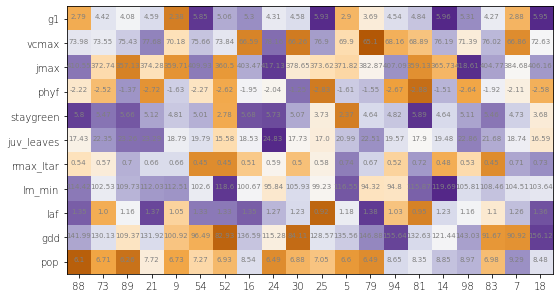

In [10]:
# Determined parameters perturbed and perturb range
problem, param_values = params_sample('present', 10)
param_range = dict(zip(problem['names'], problem['bounds']))
params = problem['names']
df_params_fold = pd.DataFrame(columns=params)

# Normalize parameter values
df_highperformance = df_params.iloc[improved_phenos, :-1]
for param in params:
    df_params_fold[param] = fold(df_highperformance[param],
                                 param_range[param][0],
                                 param_range[param][1])
    
# Visualize
fig, ax = plt.subplots(figsize=(9,6))

im = ax.imshow(df_params_fold.transpose(), cmap=PuOr_7.mpl_colormap)
ax.set_xticks(np.arange(df_highperformance.shape[0]))
ax.set_yticks(np.arange(df_highperformance.shape[1]))
ax.set_xticklabels(list(df_highperformance.index), size=10, fontweight='light')
ax.set_yticklabels(list(df_highperformance.columns), size=10, fontweight='light')

for top_pheno in range(len(improved_phenos)):
    for param in range(len(params)):
        text = ax.text(top_pheno, param,
                       df_params.transpose().loc[params[param],improved_phenos[top_pheno]],
                       ha='center', color='grey', size=7)
fig.subplots_adjust(left=0.15)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_param_values_improved_phenos_yield50_disp50.png', format='png', dpi=800)

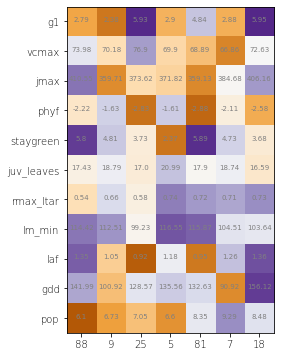

In [12]:
# Determined parameters perturbed and perturb range
problem, param_values = params_sample('present', 10)
param_range = dict(zip(problem['names'], problem['bounds']))
params = problem['names']
df_params_fold = pd.DataFrame(columns=params)

# Normalize parameter values
df_highperformance = df_params.iloc[targeted_phenos, :-1]
for param in params:
    df_params_fold[param] = fold(df_highperformance[param],
                                 param_range[param][0],
                                 param_range[param][1])
    
# Visualize
fig, ax = plt.subplots(figsize=(9,6))

im = ax.imshow(df_params_fold.transpose(), cmap=PuOr_7.mpl_colormap)
ax.set_xticks(np.arange(df_highperformance.shape[0]))
ax.set_yticks(np.arange(df_highperformance.shape[1]))
ax.set_xticklabels(list(df_highperformance.index), size=10, fontweight='light')
ax.set_yticklabels(list(df_highperformance.columns), size=10, fontweight='light')

for top_pheno in range(len(targeted_phenos)):
    for param in range(len(params)):
        text = ax.text(top_pheno, param,
                       df_params.transpose().loc[params[param],targeted_phenos[top_pheno]],
                       ha='center', color='grey', size=7)
fig.subplots_adjust(left=0.15)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_param_values_targeted_phenos_yield50_disp50.png', format='png', dpi=800)

### 80 Yield 20 Dispersion

In [13]:
# Rank all phenos
n_pheno = 100
w_yield = 0.8
w_disp = 0.2

df_rankings, phenos_ranked_present = rank_all_phenos('present', n_pheno, w_yield, w_disp)
df_rankings, phenos_ranked_f2050 = rank_all_phenos('f2050', n_pheno, w_yield, w_disp)
df_rankings, phenos_ranked_f2100 = rank_all_phenos('f2100', n_pheno, w_yield, w_disp)

df_ranks = pd.DataFrame({'pheno_present': phenos_ranked_present,
                         'pheno_f2050': phenos_ranked_f2050,
                         'pheno_f2100': phenos_ranked_f2100,
                         'rank': np.arange(100)})

df_ranks['rankdiff_2050'] = rank_diff('f2050')
df_ranks['rankdiff_2100'] = rank_diff('f2100')

df_ranks_sorted = df_ranks.sort_values(by='rankdiff_2100', ascending=False)

improved_phenos = list(df_ranks_sorted.head(20)['pheno_present'])

ranks = []
targeted_phenos = []

for pheno in improved_phenos:
    f2100_rank = df_ranks.query(f'pheno_f2100 == {pheno}')['rank'].item()
    if f2100_rank <=20:
        targeted_phenos.append(pheno)
        ranks.append(f2100_rank)

print(improved_phenos)
print(targeted_phenos)
print(ranks)

[73, 16, 54, 21, 18, 24, 25, 52, 14, 12, 79, 89, 94, 27, 98, 30, 2, 35, 29, 47]
[73, 21, 18, 12, 79, 89, 30, 29]
[13, 19, 17, 15, 18, 6, 14, 16]


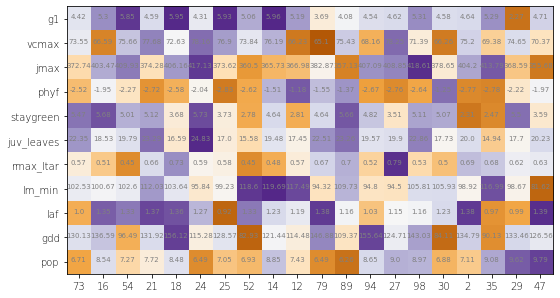

In [14]:
# Determined parameters perturbed and perturb range
problem, param_values = params_sample('present', 10)
param_range = dict(zip(problem['names'], problem['bounds']))
params = problem['names']
df_params_fold = pd.DataFrame(columns=params)

# Normalize parameter values
df_highperformance = df_params.iloc[improved_phenos, :-1]
for param in params:
    df_params_fold[param] = fold(df_highperformance[param],
                                 param_range[param][0],
                                 param_range[param][1])
    
# Visualize
fig, ax = plt.subplots(figsize=(9,6))

im = ax.imshow(df_params_fold.transpose(), cmap=PuOr_7.mpl_colormap)
ax.set_xticks(np.arange(df_highperformance.shape[0]))
ax.set_yticks(np.arange(df_highperformance.shape[1]))
ax.set_xticklabels(list(df_highperformance.index), size=10, fontweight='light')
ax.set_yticklabels(list(df_highperformance.columns), size=10, fontweight='light')

for top_pheno in range(len(improved_phenos)):
    for param in range(len(params)):
        text = ax.text(top_pheno, param,
                       df_params.transpose().loc[params[param],improved_phenos[top_pheno]],
                       ha='center', color='grey', size=7)
fig.subplots_adjust(left=0.15)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_param_values_improved_phenos_yield80_disp20.png', format='png', dpi=800)

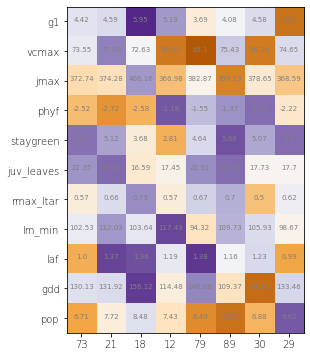

In [15]:
# Determined parameters perturbed and perturb range
problem, param_values = params_sample('present', 10)
param_range = dict(zip(problem['names'], problem['bounds']))
params = problem['names']
df_params_fold = pd.DataFrame(columns=params)

# Normalize parameter values
df_highperformance = df_params.iloc[targeted_phenos, :-1]
for param in params:
    df_params_fold[param] = fold(df_highperformance[param],
                                 param_range[param][0],
                                 param_range[param][1])
    
# Visualize
fig, ax = plt.subplots(figsize=(9,6))

im = ax.imshow(df_params_fold.transpose(), cmap=PuOr_7.mpl_colormap)
ax.set_xticks(np.arange(df_highperformance.shape[0]))
ax.set_yticks(np.arange(df_highperformance.shape[1]))
ax.set_xticklabels(list(df_highperformance.index), size=10, fontweight='light')
ax.set_yticklabels(list(df_highperformance.columns), size=10, fontweight='light')

for top_pheno in range(len(targeted_phenos)):
    for param in range(len(params)):
        text = ax.text(top_pheno, param,
                       df_params.transpose().loc[params[param],targeted_phenos[top_pheno]],
                       ha='center', color='grey', size=7)
fig.subplots_adjust(left=0.15)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_param_values_targeted_phenos_yield80_disp20.png', format='png', dpi=800)

In [19]:
# Parameters for identify_top_phenos
n_pheno = 5
n_phenos_toplot = 20
w_yield = 1
w_disp = 1

# Identify top phenos
df_pheno, mx = identify_top_phenos('f2050', n_pheno=n_pheno, w_yield=w_yield, w_disp=w_disp)

# Determine high-performing phenotypes
list_top_pheno = []
for item in np.arange(n_pheno):
    top_pheno = list(set(df_pheno.iloc[:,item]))
    list_top_pheno.extend(top_pheno)
list_top_pheno = list(set(list_top_pheno))

# Determine prevalence of phenotype occurrence
df_pheno_count = pd.DataFrame(list(pd.DataFrame(mx).count(axis=1)), columns=['count'])
top_pheno_sorted_f2050 = list(df_pheno_count.iloc[list_top_pheno].sort_values('count', ascending=False).index)    

In [20]:
# Parameters for identify_top_phenos
n_pheno = 5
n_phenos_toplot = 20
w_yield = 1
w_disp = 1

# Identify top phenos
df_pheno, mx = identify_top_phenos('present', n_pheno=n_pheno, w_yield=w_yield, w_disp=w_disp)

# Determine high-performing phenotypes
list_top_pheno = []
for item in np.arange(n_pheno):
    top_pheno = list(set(df_pheno.iloc[:,item]))
    list_top_pheno.extend(top_pheno)
list_top_pheno = list(set(list_top_pheno))

# Determine prevalence of phenotype occurrence
df_pheno_count = pd.DataFrame(list(pd.DataFrame(mx).count(axis=1)), columns=['count'])
top_pheno_sorted_present = list(df_pheno_count.iloc[list_top_pheno].sort_values('count', ascending=False).index)    

## Shift in performance distribution

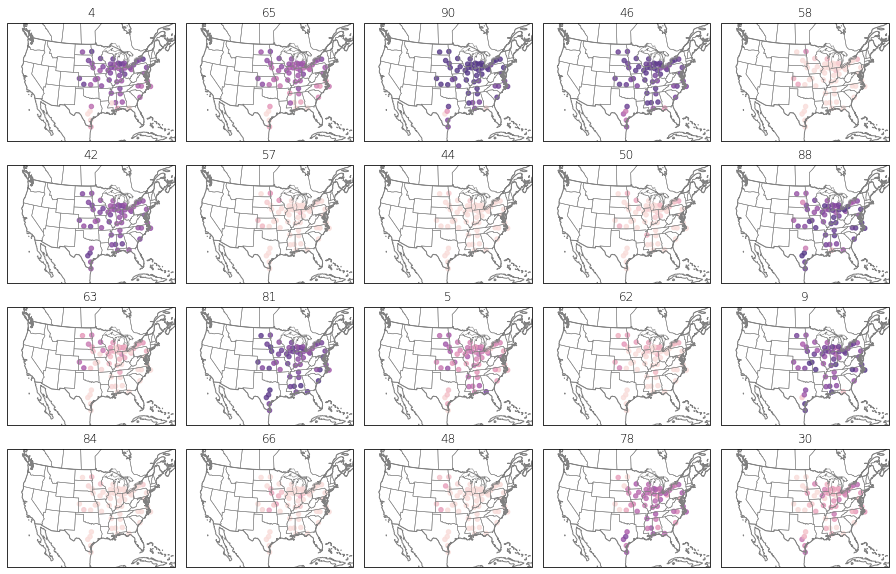

In [21]:
from palettable.cartocolors.sequential import PurpOr_6


df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_f2100.yml')
df_extended, df_stuck = parse_mature(df_all)

# Parameters for identify_top_phenos
n_pheno = 5
w_yield = 1
w_disp = 1

# Identify top phenos
df_pheno, mx = identify_top_phenos('present', n_pheno=n_pheno, w_yield=w_yield, w_disp=w_disp)

# Determine all of the high-performing phenotypes
# - not ranking any of them yet, just figuring out all the phenotypes
# - that had at least made it into top 5 at at least one location
list_top_pheno = []
for item in np.arange(n_pheno):
    top_pheno = list(set(df_pheno.iloc[:,item]))
    list_top_pheno.extend(top_pheno)
list_top_pheno = list(set(list_top_pheno))

# Determine prevalence of phenotype occurrence
# - performance determined by the counts a specific phenotype makes it
# - as the top n performers
df_pheno_count = pd.DataFrame(list(pd.DataFrame(mx).count(axis=1)), columns=['count'])
top_pheno_sorted = list(df_pheno_count.iloc[list_top_pheno].sort_values('count', ascending=False).index)    

# Visualization
fig = plt.figure(figsize=(16,10))

for item, pheno in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(4,5,item+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    mp = ax.scatter(df_sites.lon, df_sites.lat, transform=ccrs.PlateCarree(),
                    c = df_rankings.iloc[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
                    vmin=0, vmax=20, alpha=0.8, s=20)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(pheno, fontweight='light')

fig.subplots_adjust(wspace=0)
    
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/maps_top_pheno_ranking.png', format='png', dpi=800)

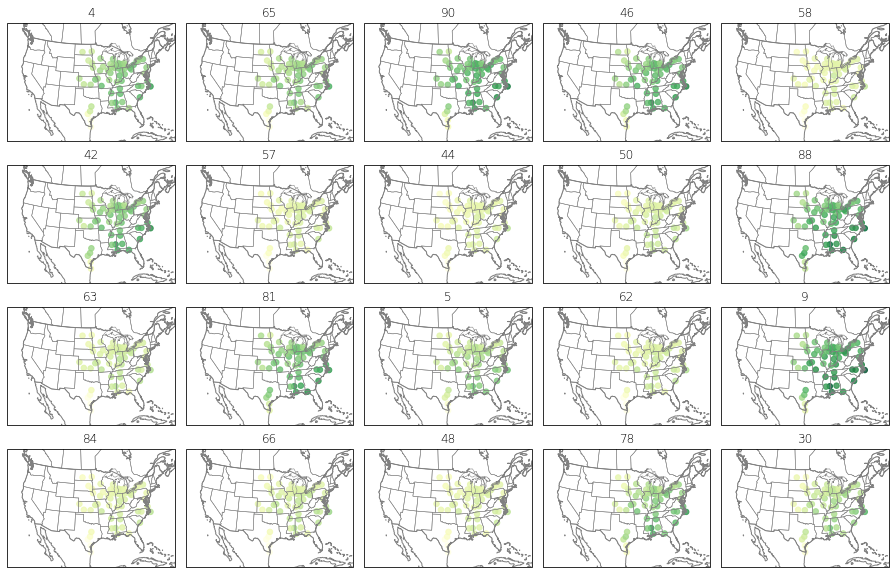

In [22]:
from palettable.colorbrewer.sequential import YlGn_9

extent = [-123, -72, 19, 53]
df_sub = df_all.groupby(['cvar', 'site']).mean().reset_index()

fig = plt.figure(figsize=(16,10))

for count, cvar in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(4,5,count+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    df = df_sub[df_sub.cvar == cvar]
    ax.scatter(df.lon, df.lat, 
               transform=ccrs.PlateCarree(), 
               s=30, c=df.dm_ear, 
               cmap=YlGn_9.mpl_colormap,
               vmin=80, vmax=250, alpha=0.8)
    ax.set_extent(extent)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(cvar, fontweight='light')

fig.subplots_adjust(wspace=0)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/maps_yield_top_phenos_sortby_top_prevalence.png', format='png', dpi=800)